Import all packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy import signal
import pandas as pd

Define and plot the given spectral density function

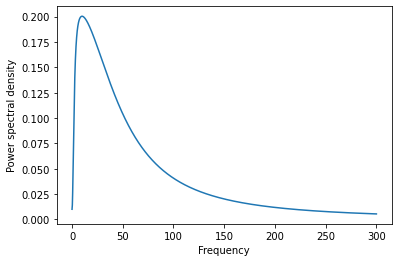

In [2]:
alpha = 5
wg = 10
kesi = 0.25

def Sx(w,alpha,wg,kesi):
    return 100*(1 + alpha*w*w)/((wg*wg - w*w)**2 + (2*kesi*w*wg*wg)**2)    # Define spectral density function

w_sample = np.linspace(0,300,1000)                                     # Visualize spectral density function
Sx_sample = Sx(w_sample,alpha,wg,kesi)

plt.plot(w_sample,Sx_sample)
plt.xlabel("Frequency")
plt.ylabel("Power spectral density")
plt.show()

Determine upper cut-off frequency wu

Basis paper: https://asmedigitalcollection.asme.org/appliedmechanicsreviews/article/44/4/191/400800/Simulation-of-Stochastic-Processes-by-Spectral

In [4]:
epsilo = 0.05

integrate_target = integrate.quad(lambda w: Sx(w,alpha,wg,kesi), 0, np.inf)[0] * (1-epsilo)

upper_frequency = 100
while upper_frequency < 10000:
    if (integrate.quad(lambda w: Sx(w,alpha,wg,kesi), 0, upper_frequency)[0] < integrate_target):
        upper_frequency = upper_frequency + 0.01
    else:
        break

print('Upper cut-off frequency wu = ',upper_frequency,'rad/s')

Upper cut-off frequency wu =  634.149999999554 rad/s


Define parameters

In [5]:
upper_frequency = 635                                             # Re-define upper cut-off frequency based on last step result
N = 500
delt_w = upper_frequency/N
T_0 = 2*np.pi/delt_w
delt_t = 0.0009                                                   # delt_t < 2pi/2wu
N1 = int(T_0/delt_t)

print('Upper frequency =', upper_frequency,'\n','Number of frequency points N =',N)
print('Frequency inteval delta w =',delt_w,'\n','Minimal period T0 =',T_0,)
print('Time interval delta t =',delt_t,'\n','Number of time points N1 =',N1)

Upper frequency = 635 
 Number of frequency points N = 500
Frequency inteval delta w = 1.27 
 Minimal period T0 = 4.947390005653218
Time interval delta t = 0.0009 
 Number of time points N1 = 5497


Generate sample functions --
Step 1: Generate uniformly distributed phase 

In [6]:
Matrix_Phi = np.zeros(N)

i = 0
while i < N:
    Matrix_Phi[i] = np.random.uniform(0,1) * 2 * np.pi
    i += 1
np.shape(Matrix_Phi)

(500,)

Step 2: Generate time series based on the formula

In [7]:
f_t1 = np.zeros(N1)

# Note: N1 is the number of time points; N is the number of frequency points

j = 0
while j < N1:
    k = 0
    while k < N:
        f_t1[j] += ((2*Sx(delt_w*k,alpha,wg,kesi)*delt_w)**0.5)*np.cos(delt_w*k*j*delt_t+Matrix_Phi[k])
        k += 1
    f_t1[j] = f_t1[j] * (2**0.5)
    j += 1
    

Visualize the 1st generated time series

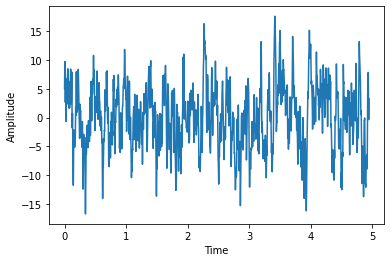

In [8]:
time = np.linspace(0,delt_t*N1,N1)
plt.plot(time,f_t1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

Step 3: Generate 24 more samples and visualize all the samples

In [9]:
ff_t = np.zeros((25,N1))

p = 0
while p < 24:
    
    Matrix_Phi = np.zeros(N)              # Renew matrix_Phi in each time series

    i = 0
    while i < N:
        Matrix_Phi[i] = np.random.uniform(0,1) * 2 * np.pi
        i += 1
    
    f_t = np.zeros(N1)
    j = 0
    while j < N1:
        k = 0
        while k < N:
            f_t[j] += ((2*Sx(delt_w*k,alpha,wg,kesi)*delt_w)**0.5)*np.cos(delt_w*k*j*delt_t+Matrix_Phi[k])
            k += 1
        f_t[j] = f_t[j] * (2**0.5)                           
        j += 1
    ff_t[p] = f_t                          # results are stored in ff_t matrix
    p += 1
    
ff_t[24] = f_t1

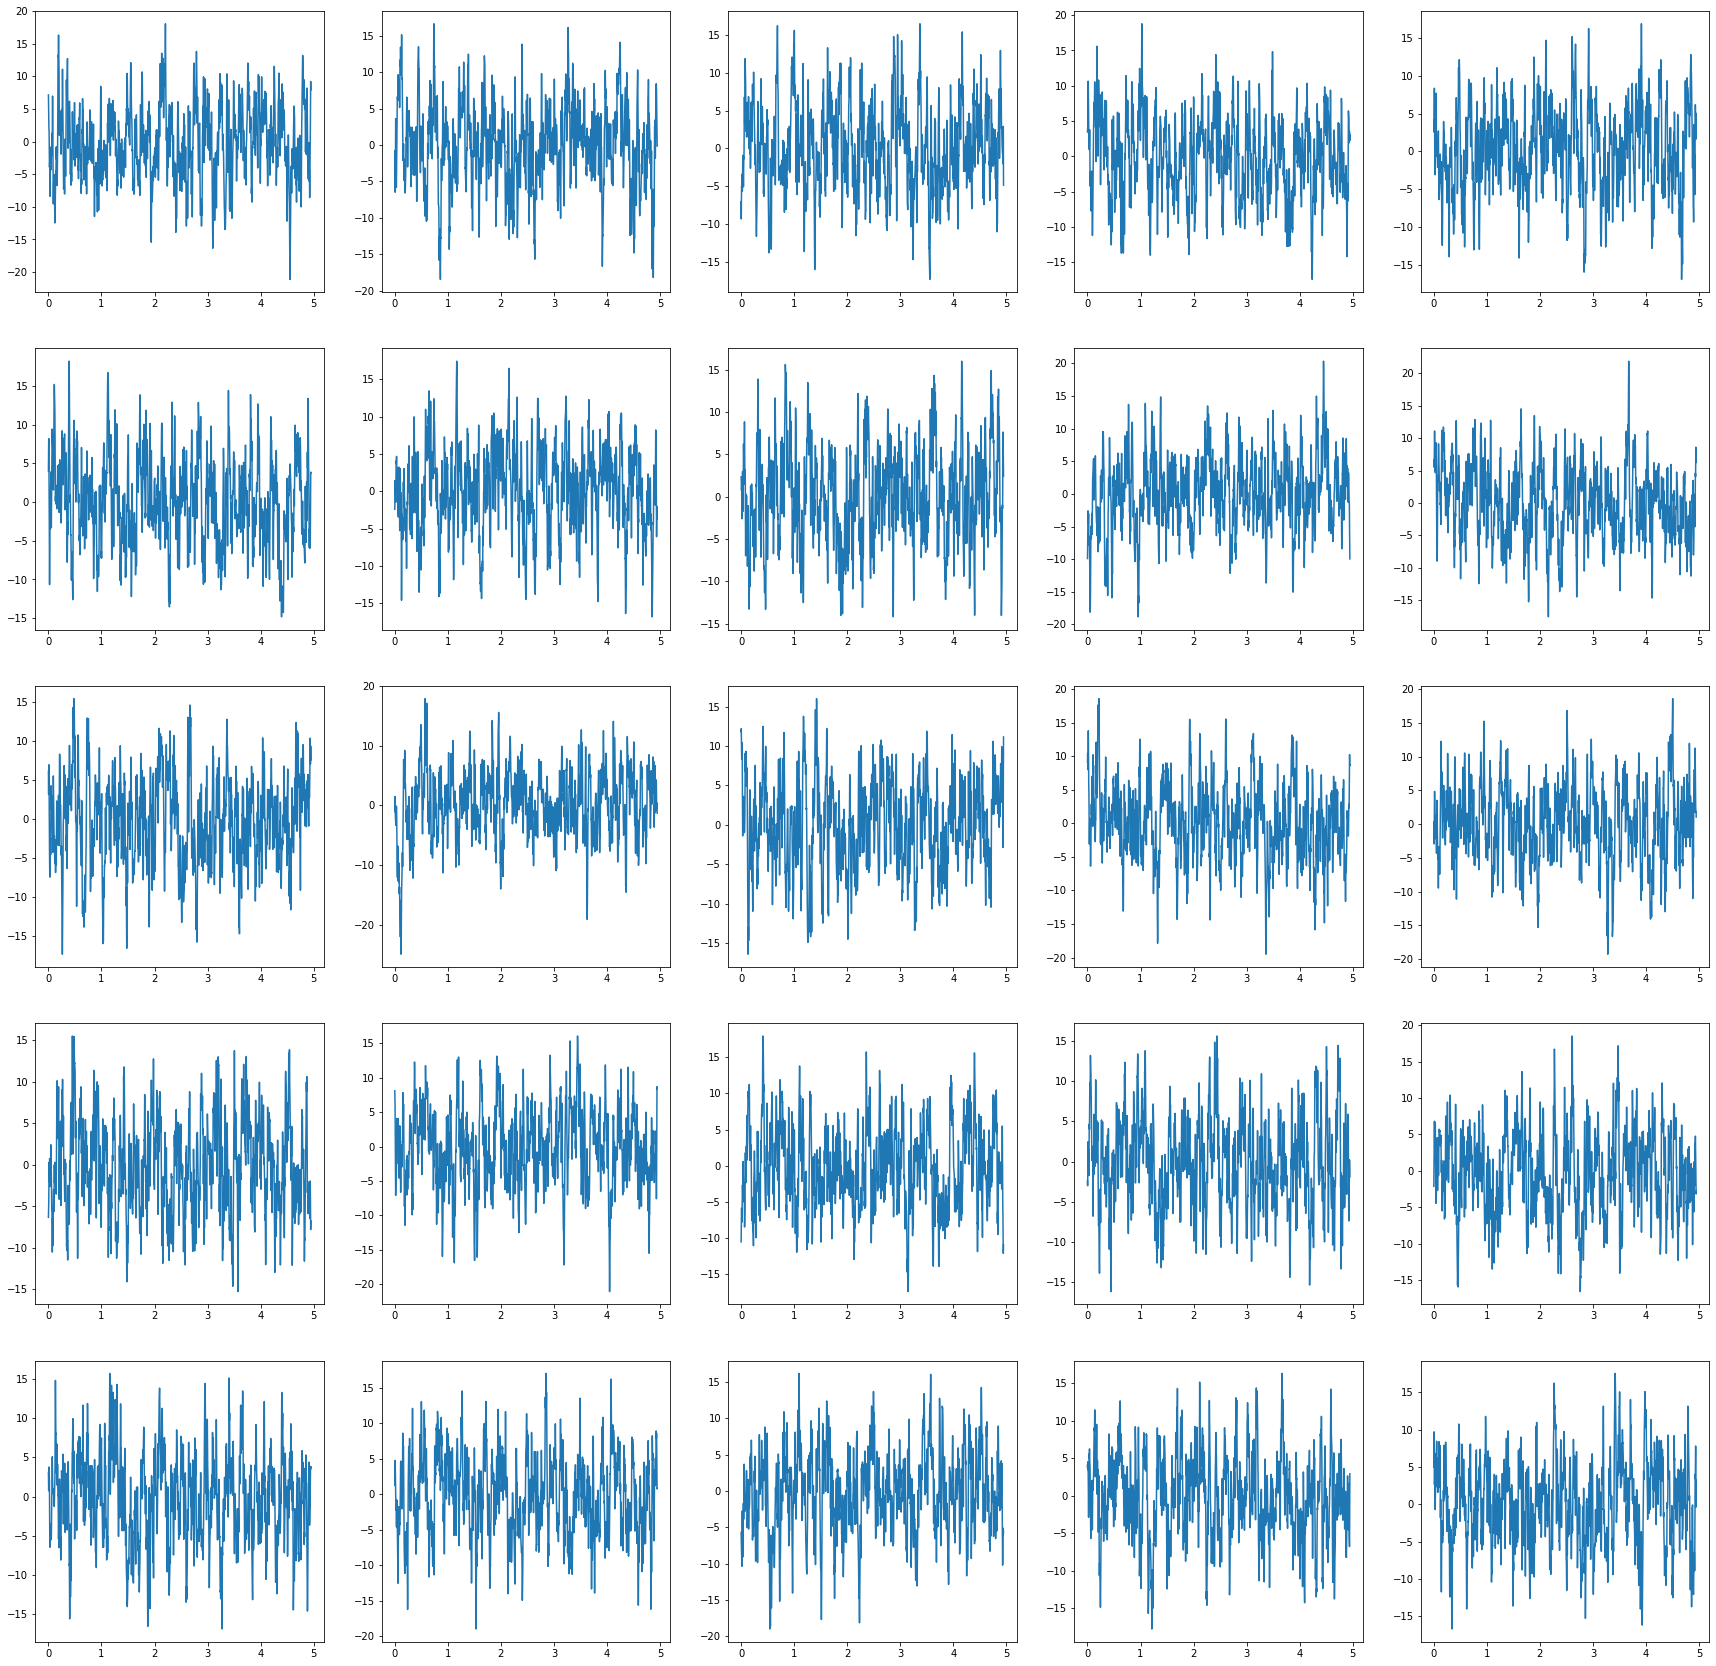

In [10]:
f, axis = plt.subplots(5, 5)

q = 0
while q < 5:
    n = 0
    while n < 5:
        axis[q, n].plot(time, ff_t[q*5+n])
        
        n += 1
    q += 1

f.set_figheight(30)
f.set_figwidth(30)


Calculate power spectral density function by using FFT

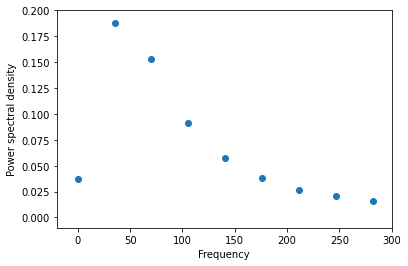

In [11]:
import warnings
warnings.filterwarnings("ignore")

f = np.zeros((25,129))
Pxx_den = np.zeros((25,129))
h = 0
while h < np.shape(ff_t)[0]:
    f[h], Pxx_den[h] = signal.welch(ff_t[h], (delt_w*7100))# choose a correct value delt_w here.

    h += 1

mean_f = f.mean(axis=0)
mean_P = Pxx_den.mean(axis=0)
plt.scatter(mean_f, mean_P)
plt.xlim((-20, 300)) 
plt.ylim((-0.01, 0.2))
plt.xlabel("Frequency")
plt.ylabel("Power spectral density")
plt.show()

Finally, export time series numpy array ff_t into csv file

In [12]:
DF = pd.DataFrame(ff_t.T)
DF                 # columns -- sample time series

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,7.157633,-0.804128,-7.020499,3.436340,4.157200,4.003024,-2.396292,2.343231,-9.896854,6.378707,...,-6.349637,8.092839,-10.567597,-2.408639,-2.132656,3.083473,1.254079,-5.708315,3.787152,5.031198
1,6.444205,-1.484566,-8.467883,3.724538,3.501714,4.531707,-1.325990,2.242919,-9.655358,6.540888,...,-6.069394,7.850776,-10.167696,-2.786112,-1.251126,2.489905,1.716934,-6.024971,4.144796,6.560245
2,5.750608,-2.255767,-9.237063,3.883052,2.916974,5.343636,-0.228647,2.072791,-9.252610,6.632193,...,-5.904031,7.594096,-9.694778,-3.015494,-0.223255,1.840385,2.289497,-6.449370,4.180652,7.880434
3,5.086105,-3.107760,-9.304849,3.921313,2.573331,6.310058,0.687721,1.827557,-8.696161,6.570608,...,-5.805314,7.293636,-9.125498,-3.015666,0.855382,1.257243,2.928250,-6.910555,4.011174,8.886653
4,4.452212,-4.003737,-8.780133,3.897950,2.599337,7.238333,1.267021,1.530021,-7.990248,6.340490,...,-5.686282,6.912877,-8.464981,-2.727998,1.901928,0.861494,3.571055,-7.335237,3.767395,9.509952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,9.089760,2.010223,2.459288,2.289424,4.065973,3.410658,-2.796136,3.527201,-7.835850,7.705890,...,-7.789405,8.373148,-12.149058,-0.441288,-2.480488,3.673027,1.422013,-5.980325,-3.106167,-0.360048
5493,9.228722,1.455234,1.303173,2.218651,4.655049,3.811602,-3.342100,3.013598,-8.729512,7.105915,...,-7.831148,8.664875,-11.958040,-0.732965,-2.926996,3.786115,0.989238,-5.849894,-1.433022,-0.160863
5494,9.020822,0.923727,-0.456436,2.345402,5.003243,3.886878,-3.704358,2.683679,-9.384655,6.612342,...,-7.611710,8.696485,-11.659778,-1.077580,-3.175879,3.851040,0.772155,-5.678612,0.246205,0.593284
5495,8.555019,0.398830,-2.601962,2.637165,5.038317,3.809012,-3.714950,2.503086,-9.788322,6.323504,...,-7.225318,8.565251,-11.317329,-1.477591,-3.155543,3.795301,0.750596,-5.550264,1.750773,1.790819


In [13]:
DF.to_csv("data.csv")

Fit polynomial function to the averaged power spectral density function

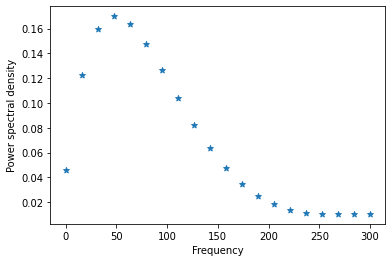

In [14]:
z = np.polyfit(mean_f, mean_P, 28)
p = np.poly1d(z)

w_fit = np.linspace(0,300,20)                                    
Sx_fit = p(w_fit)
Sx_fit[19] = Sx_fit[17]
Sx_fit[18] = Sx_fit[17]



plt.scatter(w_fit,Sx_fit,marker='*')
plt.xlabel("Frequency")
plt.ylabel("Power spectral density")
plt.show()